<a href="https://colab.research.google.com/github/promiseeselojor/British-Airways-Virtual-Internship-Program/blob/main/British_Airways_Task_2_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2 - Predicting Modeling of Customer Booking**

## **Step 1: Import Libraries**

In [ ]:
#install ydata_profiling for profile report generation
!pip install ydata_profiling

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.3

In [1]:
#install pycaret for machine learning
!pip uninstall pycaret[full]
!pip install git+https://github.com/pycaret/pycaret.git#egg=pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pycaret/pycaret.git to /tmp/pip-install-0ok1yy45/pycaret_8e31ba8968ca4a789875f0bc39058065
  Running command git clone --filter=blob:none --quiet https://github.com/pycaret/pycaret.git /tmp/pip-install-0ok1yy45/pycaret_8e31ba8968ca4a789875f0bc39058065
  Resolved https://github.com/pycaret/pycaret.git to commit 06423b8942f8480ec335e016e30938eaf260eed9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import  ProfileReport

## **Step 2: Load and View Dataset**

In [15]:
#load dataset
customer_booking_ori = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")

#create a copy of dataset
customer_booking = customer_booking_ori.copy()

#view the dataset
customer_booking.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
#function to seperate columns into categorical and numeric attributes
def separate_columns(df):
    categorical_columns = []
    numeric_columns = []
    for column in df.columns:
        if df[column].dtype == 'object':
            categorical_columns.append(column)
        else:
            numeric_columns.append(column)
    return categorical_columns, numeric_columns



In [4]:
#seperate numerical and categorical variables
categorical_columns, numeric_columns = separate_columns(customer_booking)

## **Step 3: Exploratory Data Analysis and Data Preprocessing**

I will start by utilizing the pandas_profiling library to generate a comprehensive exploratory data analysis (EDA) report for the dataset. This will simplify the process of conducting further EDA and provide valuable insights into the characteristics of the data.

In [5]:
#generate an EDA report
profile = ProfileReport(customer_booking, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#save profile report
profile.to_file("customer_booking_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Let's take care of duplicate data

In [16]:
#show number of duplicated columns
customer_booking.duplicated().sum()

719

In [17]:
#drop duplicates
customer_booking.drop_duplicates(inplace = True)

In [18]:
customer_booking.shape

(49281, 14)

I'm going to first create an unseen test sample from the dataset where our final model will be tested upon

In [19]:
#create a sample containing 90% from the dataset
data = customer_booking.sample(frac =0.9, random_state=786)

#create a dataset of the remaining 10% left
data_unseen = customer_booking.drop(data.index)

data.reset_index(drop=True, inplace =True)
data_unseen.reset_index(drop=True, inplace = True)

print('Data for modeling: ' + str(data.shape))
print('Unseen data for predictions: ' + str(data_unseen.shape))

Data for modeling: (44353, 14)
Unseen data for predictions: (4928, 14)


### **Target Variable and Numeric Variable Analysis**

To find out more about the relationships between the attributes and the target variable, i'm going to run a T-test and ANOVA test

In [20]:
from scipy import stats

#function to carry out t-test
def t_test_summary(df, target_variable):
    """
    Perform a t-test between the target variable and each numeric column in a dataframe,
    and return a summary table of the results.
    """
    results = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if col != target_variable:
            t, p = stats.ttest_ind(df[target_variable], df[col])
            results.append({'column': col, 't': t, 'p': format(p, '.2e')})
    return pd.DataFrame(results).set_index('column').sort_values('p')



In [21]:
t_test_summary(customer_booking, 'booking_complete')

,t,p
column,,
num_passengers,-296.742973,0.00e+00
purchase_lead,-207.659640,0.00e+00
length_of_stay,-150.278658,0.00e+00
flight_hour,-365.048012,0.00e+00
wants_extra_baggage,-194.693037,0.00e+00
wants_preferred_seat,-55.804933,0.00e+00
wants_in_flight_meals,-100.681243,0.00e+00
flight_duration,-1028.869638,0.00e+00


In [22]:
#ANOVA test function
def anova_test_summary(df, target_variable):
    """
    Perform an ANOVA test between the target variable and each numeric column in a dataframe,
    and return a summary table of the results.
    """
    results = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if col != target_variable:
            f_val, p_val = stats.f_oneway(df[target_variable], df[col])
            results.append({'column': col, 'f_value': f_val, 'p_value': p_val})
    return pd.DataFrame(results).set_index('column').sort_values('p_value')


In [23]:
anova_test_summary(customer_booking, 'booking_complete')

,f_value,p_value
column,,
num_passengers,8.805639e+04,0.0
purchase_lead,4.312253e+04,0.0
length_of_stay,2.258367e+04,0.0
flight_hour,1.332601e+05,0.0
wants_extra_baggage,3.790538e+04,0.0
wants_preferred_seat,3.114191e+03,0.0
wants_in_flight_meals,1.013671e+04,0.0
flight_duration,1.058573e+06,0.0


The T-test and anova test shows p values are approximately equal to zero(floating-precision) indicating a strong rejection of the null hypothesis. This means that the features have a significant predictive power.

**Preprocessing Tasks**

Based on the EDA report generated above, we can observe that the **'route'** attribute and **'booking_origin'** has high cardinality and imbalanced distribution. It has 799, and 104 unique values, respectively which will pose a challenge for one-hot encoding. 

As a result, I'm going to apply target encoding which replaces the categories with the mean target values for that category

The **'num_passengers'** attribute has a low variance which indicates that most of the values are the same. Thus I will also remove it from the dataset.

The **trip_type** and **'sales_channel'** attribute has a low entropy, with 99% of the trips being round trips. I will remove them as well due to this imbalance.

From the descriptive statistics and histograms of the **'purchase_lead'** and **'length_of_stay'** attributes, we can observe that they are heavily right-skewed, indicating the presence of outliers. To mitigate this issue, I will need to handle the outliers

The target labels **(booking_complete)** are imbalanced with a majority of class 0 values, which is significantly higher compared to the class 1 values. To address this imbalance, I will use the Synthetic Minority Over-sampling Technique (SMOTE) to oversample the minority class. 

Since the dataset is small, oversampling the minority class will ensure that the classifier has enough samples to learn the patterns in the minority class.

Lastly i will need to normalize the numeric attributes so they have the same scale

Let's implement all of our preprocessing tasks outlined above using the transformation pipeline from the setup class providing by pycaret

In [24]:
#drop num_passengers and trip_type column before passing into the transforamtion pipeline
customer_booking = customer_booking.drop(['trip_type', 'num_passengers', 'sales_channel'], axis = 1)


In [25]:
#Initialize the transformation pipeline

from category_encoders import TargetEncoder

te = TargetEncoder()

from pycaret.classification import *
clf1 = setup(
    session_id = 123,
    data = customer_booking,
    target = 'booking_complete',
    fix_imbalance = True,
    remove_multicollinearity = True,
    remove_outliers = True,
    normalize = True,
    encoding_method= te
)

,Description,Value
0,Session id,123
1,Target,booking_complete
2,Target type,Binary
3,Original data shape,"(49281, 11)"
4,Transformed data shape,"(70825, 17)"
5,Transformed train set shape,"(56040, 17)"
6,Transformed test set shape,"(14785, 17)"
7,Numeric features,7
8,Categorical features,3
9,Preprocess,True


## **Step 4: Train The Model**

In [26]:
#check out list of models avalaible for the classification task
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Let's find the best model for this classification problem and sort result by AUC. The target variables are imbalanced which means accuracy wont be the major metric i'm looking at

In [27]:
best_model = compare_models(sort='AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:02:06
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7133,0.7721,0.6997,0.3029,0.4226,0.2698,0.3118,4.9700
rf,Random Forest Classifier,0.8416,0.7638,0.1875,0.4357,0.2619,0.1887,0.2100,8.6270
nb,Naive Bayes,0.7291,0.7611,0.6693,0.3120,0.4255,0.2778,0.3126,0.6520
ada,Ada Boost Classifier,0.8147,0.7582,0.2924,0.3572,0.3210,0.2151,0.2168,3.3610
qda,Quadratic Discriminant Analysis,0.7109,0.7394,0.5953,0.2928,0.3734,0.2228,0.2573,0.3950
knn,K Neighbors Classifier,0.7606,0.6799,0.4090,0.2891,0.3386,0.1977,0.2022,17.6940
dt,Decision Tree Classifier,0.7717,0.5890,0.3278,0.2783,0.3010,0.1656,0.1665,2.1890
svm,SVM - Linear Kernel,0.6904,0.0000,0.7406,0.2911,0.4178,0.2580,0.3104,0.5760
ridge,Ridge Classifier,0.7145,0.0000,0.7020,0.3043,0.4245,0.2722,0.3144,0.4400


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8458,0.7768,0.1432,0.4549,0.2176,0.1572,0.1900,1.3230
gbc,Gradient Boosting Classifier,0.8383,0.7751,0.1998,0.4217,0.2703,0.1923,0.2097,11.1740
lda,Linear Discriminant Analysis,0.7145,0.7723,0.7020,0.3043,0.4245,0.2722,0.3144,0.8150
lr,Logistic Regression,0.7133,0.7721,0.6997,0.3029,0.4226,0.2698,0.3118,4.9700
rf,Random Forest Classifier,0.8416,0.7638,0.1875,0.4357,0.2619,0.1887,0.2100,8.6270
nb,Naive Bayes,0.7291,0.7611,0.6693,0.3120,0.4255,0.2778,0.3126,0.6520
ada,Ada Boost Classifier,0.8147,0.7582,0.2924,0.3572,0.3210,0.2151,0.2168,3.3610
et,Extra Trees Classifier,0.8331,0.7455,0.2149,0.3962,0.2785,0.1935,0.2051,7.3590
qda,Quadratic Discriminant Analysis,0.7109,0.7394,0.5953,0.2928,0.3734,0.2228,0.2573,0.3950
knn,K Neighbors Classifier,0.7606,0.6799,0.4090,0.2891,0.3386,0.1977,0.2022,17.6940


My main criteria for selecting the models is high AUC, recall, precision and f1.Since the target variable is imbalanced, i wont rely too heavily on accuracy as a performance metric. 

Instead, I will focus on metrics that are more appropriate for imbalanced data, such as AUC (area under the ROC curve), recall, precision, and F1 score. 

By prioritizing these metrics, i can select models that are more likely to correctly identify the positive class (customers who book a holiday) and minimize the number of false negatives (customers who are likely to book a holiday but are not targeted by our marketing campaigns).

In [28]:
#train the Linear Discriminant Analysis Model
lda = create_model('lda', fold = 5)
lda_results = pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7270,0.7750,0.6976,0.3149,0.4339,0.2864,0.3257
1,0.7102,0.7627,0.6618,0.2935,0.4066,0.2509,0.2873
2,0.7078,0.7830,0.7314,0.3034,0.4289,0.2752,0.3233
3,0.7147,0.7580,0.6676,0.2985,0.4125,0.2589,0.2955
4,0.7233,0.7786,0.7089,0.3131,0.4344,0.2859,0.3277
Mean,0.7166,0.7715,0.6935,0.3047,0.4233,0.2715,0.3119
Std,0.0074,0.0095,0.0259,0.0082,0.0115,0.0143,0.0170


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
#train a logistic regression model
lr = create_model('lr', fold =5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7259,0.7745,0.6986,0.3141,0.4333,0.2854,0.3251
1,0.7087,0.7629,0.6609,0.2919,0.4050,0.2486,0.2850
2,0.7055,0.7826,0.7343,0.3019,0.4279,0.2735,0.3224
3,0.7120,0.7577,0.6686,0.2962,0.4106,0.2558,0.2930
4,0.7210,0.7782,0.7012,0.3097,0.4296,0.2799,0.3209
Mean,0.7146,0.7712,0.6927,0.3028,0.4213,0.2686,0.3093
Std,0.0077,0.0094,0.0262,0.0082,0.0113,0.0141,0.0168


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
#train a Naive Bayes model
nb = create_model('nb', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7412,0.7590,0.6415,0.3194,0.4265,0.2828,0.3115
1,0.7255,0.7519,0.6271,0.3009,0.4066,0.2557,0.2849
2,0.7217,0.7618,0.6995,0.3103,0.4299,0.2804,0.3209
3,0.7305,0.7540,0.6560,0.3112,0.4221,0.2745,0.3070
4,0.7371,0.7666,0.6692,0.3198,0.4328,0.2884,0.3218
Mean,0.7312,0.7586,0.6587,0.3123,0.4236,0.2764,0.3092
Std,0.0072,0.0053,0.0248,0.0070,0.0092,0.0112,0.0134


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [31]:
#train a quadratic discriminant analysis(QDA) model
qda = create_model('qda', fold =5)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7461,0.7517,0.5961,0.3162,0.4133,0.2702,0.2923
1,0.7291,0.7438,0.6019,0.2995,0.4000,0.2497,0.2750
2,0.7060,0.7554,0.6966,0.2961,0.4156,0.2597,0.3021
3,0.7447,0.7374,0.5343,0.3019,0.3858,0.2401,0.2557
4,0.8066,0.7656,0.4410,0.3762,0.4061,0.2914,0.2928
Mean,0.7465,0.7508,0.5740,0.3180,0.4041,0.2622,0.2836
Std,0.0333,0.0097,0.0843,0.0299,0.0107,0.0177,0.0165


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## **Step 5: Model Optimization and Hyperparameter Tuning**

In [32]:
#hyperparameter tuning for the lda model.
lda_tuner, tuned_lda = tune_model(lda, choose_better =True, return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7313,0.7732,0.6795,0.3163,0.4316,0.2852,0.3209
1,0.7226,0.7802,0.7162,0.3141,0.4367,0.2881,0.3312
2,0.7023,0.7565,0.6737,0.2891,0.4046,0.2463,0.2855
3,0.7113,0.7720,0.6815,0.2981,0.4148,0.2603,0.2995
4,0.7061,0.7893,0.7485,0.3045,0.4329,0.2794,0.3309
5,0.7130,0.7783,0.7195,0.3057,0.4291,0.2770,0.3223
6,0.7135,0.7753,0.7157,0.3055,0.4282,0.2762,0.3207
7,0.7057,0.7411,0.6576,0.2886,0.4012,0.2436,0.2799
8,0.7208,0.7775,0.7195,0.3126,0.4359,0.2868,0.3308


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [33]:
#hyperparameter tuning for the lr model.
lr_tuner, tuned_lr = tune_model(lr, choose_better =True, return_tuner=True)
lr_tuner_results = pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7293,0.7721,0.6737,0.3133,0.4277,0.2801,0.3154
1,0.7232,0.7801,0.7201,0.3153,0.4386,0.2904,0.3340
2,0.7014,0.7572,0.6737,0.2884,0.4039,0.2452,0.2845
3,0.7101,0.7713,0.6776,0.2965,0.4125,0.2573,0.2961
4,0.7029,0.7886,0.7505,0.3022,0.4309,0.2762,0.3286
5,0.7133,0.7782,0.7215,0.3062,0.4300,0.2781,0.3237
6,0.7109,0.7744,0.7079,0.3020,0.4234,0.2699,0.3136
7,0.7037,0.7413,0.6460,0.2847,0.3953,0.2364,0.2712
8,0.7196,0.7776,0.7195,0.3116,0.4348,0.2853,0.3295


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [34]:
#hyperparameter tuning for the Naive Bayes model.
nb_tuner, tuned_nb = tune_model(nb, choose_better =True, return_tuner=True)
nb_tuner_result = pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7371,0.7506,0.6255,0.3124,0.4167,0.2707,0.2978
1,0.7374,0.7747,0.6660,0.3200,0.4323,0.2879,0.3206
2,0.7191,0.7489,0.6544,0.3003,0.4117,0.2592,0.2931
3,0.7243,0.7558,0.6486,0.3041,0.4140,0.2635,0.2958
4,0.7246,0.7732,0.7137,0.3151,0.4372,0.2895,0.3319
5,0.7290,0.7656,0.7176,0.3198,0.4425,0.2966,0.3389
6,0.7338,0.7750,0.6983,0.3215,0.4402,0.2956,0.3339
7,0.7150,0.7330,0.6209,0.2897,0.3951,0.2396,0.2695
8,0.7318,0.7667,0.6731,0.3152,0.4294,0.2830,0.3178


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [35]:
#hyperparameter tuning for the Quadratic Discriminant Analysis(QDA) model.
qda_tuner, tuned_qda = tune_model(qda, choose_better =True, return_tuner=True)
qda_tuned_results = pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7510,0.7491,0.6158,0.3258,0.4262,0.2860,0.3096
1,0.7441,0.7794,0.6641,0.3267,0.4379,0.2963,0.3276
2,0.7255,0.7521,0.6158,0.2990,0.4025,0.2511,0.2788
3,0.7319,0.7621,0.6197,0.3060,0.4097,0.2612,0.2884
4,0.7296,0.7778,0.6905,0.3159,0.4335,0.2869,0.3247
5,0.7339,0.7666,0.6731,0.3172,0.4312,0.2857,0.3202
6,0.7353,0.7735,0.6538,0.3153,0.4254,0.2798,0.3112
7,0.7205,0.7332,0.5899,0.2886,0.3875,0.2332,0.2582
8,0.7437,0.7697,0.6518,0.3237,0.4326,0.2905,0.3202


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [36]:
#assign the results from the tuned lda into a variable
lda_tuned_results = pull()

Let's try some ensemble methods, stacking and blending to see if we can get better results






In [37]:
#stacking lda lr nb and qda models
stacked_models = stack_models([lda, lr, nb, qda])
stacked_results = pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7548,0.7411,0.5849,0.3244,0.4174,0.2779,0.2972
1,0.7545,0.7528,0.6120,0.3292,0.4281,0.2893,0.3119
2,0.7377,0.7354,0.6042,0.3090,0.4089,0.2623,0.2867
3,0.7319,0.7384,0.6023,0.3026,0.4028,0.2537,0.2787
4,0.7542,0.7583,0.5841,0.3230,0.4160,0.2763,0.2958
5,0.7322,0.7572,0.6847,0.3175,0.4338,0.2880,0.3245
6,0.7440,0.7510,0.5996,0.3144,0.4125,0.2687,0.2916
7,0.7683,0.7013,0.4429,0.3095,0.3644,0.2281,0.2336
8,0.7312,0.7450,0.6654,0.3133,0.4260,0.2791,0.3128


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
#stacking lda lr nb and qda models
blended_models = blend_models([lda, lr, nb, qda])
blended_results = pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7470,0.7720,0.6525,0.3278,0.4364,0.2956,0.3248
1,0.7229,0.7817,0.7008,0.3119,0.4316,0.2825,0.3230
2,0.7151,0.7581,0.6544,0.2966,0.4082,0.2540,0.2886
3,0.7136,0.7703,0.6834,0.3005,0.4175,0.2639,0.3031
4,0.7380,0.7862,0.6905,0.3243,0.4413,0.2981,0.3345
5,0.6971,0.7753,0.7621,0.2994,0.4299,0.2736,0.3290
6,0.7338,0.7792,0.6809,0.3186,0.4340,0.2888,0.3244
7,0.7483,0.7398,0.5261,0.3039,0.3853,0.2410,0.2554
8,0.7019,0.7757,0.7427,0.3002,0.4276,0.2722,0.3233


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [40]:
#visualizing the results of all models in a tabular format
lda_tuner_results_df = lda_tuned_results.loc[['Mean']]
lr_tuner_results_df = lr_tuner_results.loc[['Mean']]
nb_tuner_results_df = nb_tuner_result.loc[['Mean']]
qda_tuner_results_df = qda_tuned_results.loc[['Mean']]
stacked_results_df = stacked_results.loc[['Mean']]
blended_results_df = blended_results.loc[['Mean']]

#merge dataframes
comparison_df = pd.concat([ 
   lda_tuner_results_df,
   lr_tuner_results_df,
   nb_tuner_results_df,
   qda_tuner_results_df,
   stacked_results_df,
   blended_results_df, 
]).reset_index()

comparison_df = comparison_df.drop('Fold', axis = 1)
comparison_df.insert(0, "Model",  ['lda_tuner','lr_tuner','nb_tuner','qda_tuner','stacked_models', 'blended_models'], )

comparison_df.style.highlight_max(color= 'lightgreen', axis = 0)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,lda_tuner,0.736300,0.763600,0.642600,0.314700,0.422300,0.276700,0.306400
1,lr_tuner,0.713300,0.772100,0.699700,0.302900,0.422600,0.269800,0.311800
2,nb_tuner,0.729100,0.761100,0.669300,0.312000,0.425500,0.277800,0.312600
3,qda_tuner,0.736300,0.763600,0.642600,0.314700,0.422300,0.276700,0.306400
4,stacked_models,0.745400,0.741900,0.598000,0.315900,0.412400,0.269400,0.292700
5,blended_models,0.724100,0.771300,0.677000,0.309100,0.423500,0.274300,0.311600


## **Step 6: Model Evaluation**

I'm going to run some expected value analysis on the models to calculate it's cost-benefit and expected profit so we can derive the best model and make better decisions

First we are going to calculate the probaility rates of the different models from the cell values of the confusion matrix

Next we'll aluclate the cost-benefit of each of these scenarios. To do that let's assume the average cost of acquiring a customer through marketing campaigns is 700 per customer and the average revenue per customer is $3,500(CAC to LTV ratio of 1:5) 

*   A true positive is a customer who is offered the product and buys it. The benefit is the revenue minus costs which is $2,800. The benefit in this case is 2,800
*   A false positive is when we classfiy a customer as likely to book a holiday, and therefore target her but she doesnt respond. Since the cost of marketing is 700, the cost in this case is -700
*   A false negative is a customer who was predicted not to book a holiday(and was not offered a promotion) but would have bought it if offered. Since no promotion was done to this customer, the cost is 0. But i would argue that this is missed opportunity to gain 2,800. But for simplicity lets use 0
*   A true negative is a customer who wasnt offered a deal and who wouldn't have bought even if it was offered. The benefit in this case is 0

With this we can calculate the expected value of each of the scearios by multiplying the probaility by the cost benefit

Becuase the target variables is imbalanced, we will use conditional probaility instead of the traditional sum of all expected values

Expected value of the model = Probility of a customer not booking x (Expected Value of True Positive + Expected Value of False Negative) + Probaility of a customer booking X (Expected Value of True Negative + Expected Value of False Positive)

Let's automate this process using code to calculate the EV of the reamining models

In [103]:
#write a function to calculate the expected values of models given probility and cost-benefit

def calculate_expected_value (tn, fp, fn, tp):
  total = tp + fp + fn + tn
  
  prob_target_true = (tp + fp)/total
  prob_target_false = (fn+tn)/total

  prob_true_positive = float(tp/total)
  prob_true_negative = float(tn/total)
  prob_false_positive = float(fp/total)
  Prob_false_negative = float(fn/total)

  cost_true_positive =  2800
  cost_true_negative = 0
  cost_false_positive = -700
  cost_false_negative = 0

  ev_true_positive = prob_true_positive * cost_true_positive
  ev_true_negative = prob_true_negative * cost_true_negative
  ev_false_positive = prob_false_positive * cost_false_positive
  ev_false_negative = Prob_false_negative * cost_false_negative

  expected_value = prob_target_true * (ev_true_positive + ev_false_positive) + prob_target_false * (ev_false_negative + ev_true_negative)

  return expected_value

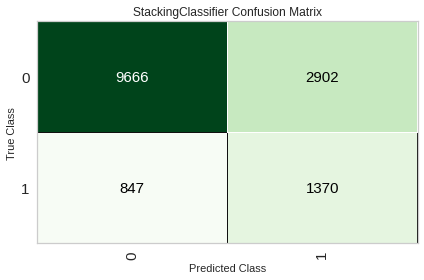

In [41]:
#display confusion matrix for the stacked models
stacked_models_confusion_matrix = plot_model(stacked_models, plot ='confusion_matrix')

In [104]:
stacked_models_expected_value = calculate_expected_value(9666, 2902,847,1370)
stacked_models_expected_value

35.26708295168409

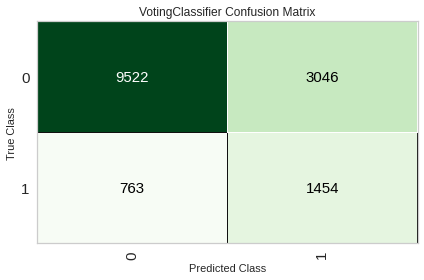

In [84]:
#display confusion matrix for the blended models
blended_models_confusion_matrix = plot_model(blended_models, plot ='confusion_matrix')

In [105]:
blended_models_expected_value = calculate_expected_value(9522, 3046,763,1454)
blended_models_expected_value

39.91605984961542

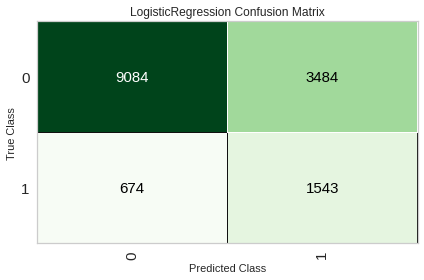

In [44]:
#display confusion matrix for the optimized Logistic Regression model
lr_tuner_confusion_matrix = plot_model(lr_tuner, plot ='confusion_matrix')

In [106]:
lr_expected_value = calculate_expected_value(9084, 3484,674,1543)
lr_expected_value

43.27066123854608

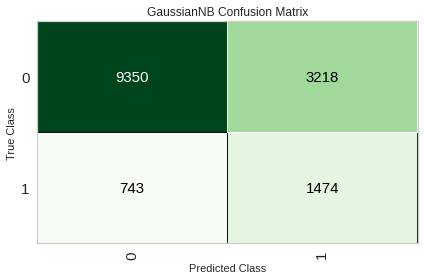

In [45]:
#display confusion matrix for the optimized Naive Bayes Model
nb_tuner_confusion_matrix = plot_model(nb_tuner, plot ='confusion_matrix')

In [107]:
nb_expected_value = calculate_expected_value(9350, 3218,743,1474)
nb_expected_value

40.236848554909855

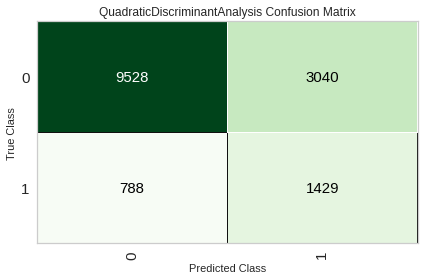

In [46]:
#display confusion matrix for the optimized qda model
qda_tuner_confusion_matrix = plot_model(qda_tuner, plot ='confusion_matrix')

In [108]:
qda_expected_value = calculate_expected_value(9528, 3040,788,1429)
qda_expected_value

38.29586169660523

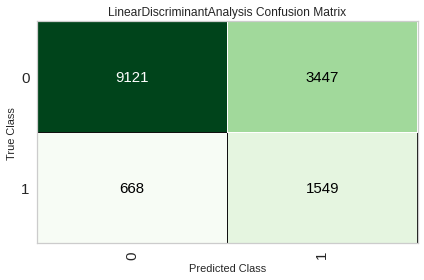

In [ ]:
#display confusion matrix for the optimized LDA model
lda_tuner_confusion_matrix = plot_model(lda_tuner, plot ='confusion_matrix')

In [109]:
lda_expected_value = calculate_expected_value(9121, 3447, 668, 1549)
lda_expected_value

43.979729293129374

Based on the analysis, the Linear Discriminant Model produces the highest expected value of **$43.97 per customer**

## **Step 7: Prediction On Test Sample**

In [112]:
#predict model on test set
test_result = predict_model(lda_tuner)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7217,0.7765,0.6987,0.3100,0.4295,0.2799,0.3204


There's no signicant different between the test results and training results, so the model is ok

## **Step 8: Finalize the Model for Deployment**

In [113]:
#train the model on both trainX part and testX part
final_lda_model = finalize_model(lda_tuner)
final_lda_model

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['purchase_lead', 'length_of_stay',
                                             'flight_hour',
                                             'wants_extra_baggage',
                                             'wants_preferred_seat',
                                             'wants_in_flight_meals',
                                             'flight_duration'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              missing_values=nan,
                                                              strate...
                                                             

## **Step 9: Predict on Unseen Data**

In [114]:
#predict model on the unseen data we created initally
predictions = predict_model(final_lda_model, data =data_unseen)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7177,0.7845,0.7095,0.3110,0.4325,0.2809,0.3232


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,prediction_label,prediction_score
0,1,Internet,RoundTrip,3,48,20,Thu,AKLDEL,New Zealand,1,0,1,5.52,0,0,0.8103
1,4,Internet,RoundTrip,265,24,19,Mon,AKLDEL,New Zealand,1,0,1,5.52,0,0,0.8500
2,1,Internet,RoundTrip,245,34,4,Tue,AKLDEL,New Zealand,1,1,1,5.52,0,0,0.8295
3,1,Internet,RoundTrip,65,17,9,Wed,AKLICN,New Zealand,1,0,0,6.62,0,0,0.9078
4,1,Internet,RoundTrip,22,89,14,Tue,AKLICN,South Korea,1,0,1,6.62,0,0,0.8587


The model also provides class probabilities (prediction_score), which can be used to draw a profit curve that shows the expected profit and loss for different decision thresholds. By analyzing this curve, we can make more informed decisions and allocate resources more effectively, based on the expected costs and benefits of different marketing strategies.

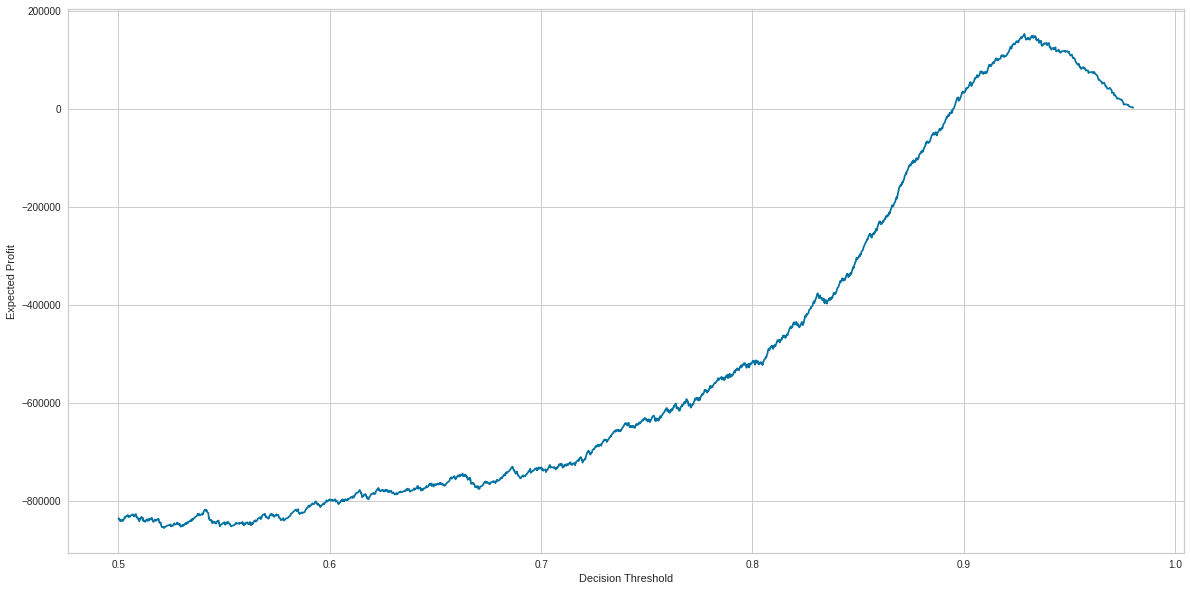

In [121]:

from sklearn.metrics import confusion_matrix

# Define profit function
def profit(y_true, y_pred):
    # Specify profit and loss for each possible outcome
    tp_profit = 2800  # True positive: correct prediction
    fp_loss = -700    # False positive: incorrect prediction
    tn_profit = 0   # True negative: correct rejection
    fn_loss = 0    # False negative: incorrect rejection
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate profit based on confusion matrix
    profit = (cm[0, 0] * tn_profit + cm[0, 1] * fp_loss
              + cm[1, 0] * fn_loss + cm[1, 1] * tp_profit)
    
    return profit

# Calculate expected profit for each decision threshold
thresholds = sorted(predictions['prediction_score'].unique())
profits = []
for threshold in thresholds:
    y_pred = predictions['prediction_score'] >= threshold
    p = profit(predictions['booking_complete'], y_pred)
    profits.append(p)

# Plot profit curve
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(thresholds, profits)
plt.xlabel('Decision Threshold')
plt.ylabel('Expected Profit')
plt.show()

## **Recommendations**

Based on the profit curve, we can identify the decision threshold that maximizes the expected profit. In this case, the curve reaches its maximum at a threshold of around 93%. 

To maximize profit, it's recommended we only target customers whose predicted probability of booking a holiday is greater than or equal to 89% in our marketing campaigns.

Using a higher threshold may reduce the number of customers that we target, but it also increases the likelihood that the customers we do target will actually book a holiday. This can lead to a higher overall profit, as the expected profit per customer will be greater.

However, it's important to consider other factors that may impact our marketing strategy, such as the size and diversity of the customer base, the marketing budget, and the potential impact on customer satisfaction and brand reputation. The decision threshold should be chosen based on a holistic evaluation of these factors, and may be adjusted over time based on the performance of the model and the evolving needs of the business.

## **Step 10: Save the model**

In [123]:
save_model(final_lda_model, 'Final_British_Airways_LDA_Prediction_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['purchase_lead', 'length_of_stay',
                                              'flight_hour',
                                              'wants_extra_baggage',
                                              'wants_preferred_seat',
                                              'wants_in_flight_meals',
                                              'flight_duration'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               missing_values=nan,
                                                               strate...
                                               